## Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [201]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
root_path = '/content/drive/My Drive/AIML/Lab9 Melbourne Temperature'  #change dir to your project folder

In [203]:
ls

drive/  sample_data/


### Load your data file

In [0]:
import os
import time
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2

In [0]:
mtemp=pd.read_csv('/content/drive/My Drive/AIML/Lab9 Melbourne Temperature/daily-minimum-temperatures-in-me.csv')

In [206]:
mtemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null object
Temperature    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [207]:
mtemp.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [208]:
mtemp.count()

Date           3650
Temperature    3650
dtype: int64

In [209]:
mtemp.Date.unique()

array(['1981-01-01', '1981-01-02', '1981-01-03', ..., '1990-12-29',
       '1990-12-30', '1990-12-31'], dtype=object)

#### Plot data

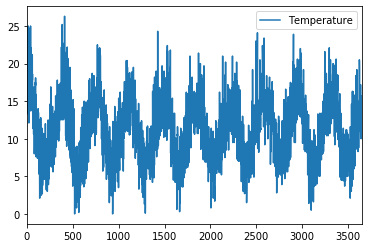

In [210]:
mtemp.plot()

#### Describe your dataframe

In [211]:
mtemp.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


#### Check for null values

In [212]:
mtemp.isnull().sum()

Date           0
Temperature    0
dtype: int64

*Observation :There are no NULL values in dataset*

#### Drop null values

In [213]:
#there are no null values, still running below code to drop NULL values
mtemp.dropna()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


#### Get the representation of the distribution of data in the form of histogram

Text(0.5, 0, 'Date')

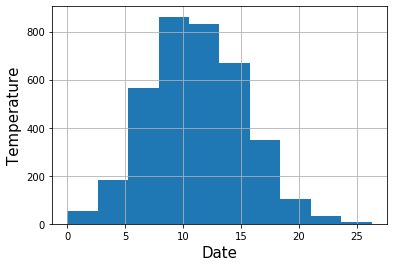

In [214]:
mtemp['Temperature'].hist(bins=10)
plt.ylabel("Temperature", fontsize=15)
plt.xlabel("Date",fontsize=15)

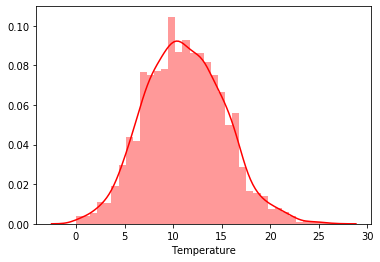

In [215]:
sns.distplot(mtemp['Temperature'], color='red')

#### Check the maximum and minimum values

In [216]:
mtemp[mtemp['Temperature']==mtemp['Temperature'].max()]

,Date,Temperature
410,1982-02-15,26.3


In [217]:
mtemp[mtemp['Temperature']==mtemp['Temperature'].min()]

,Date,Temperature
520,1982-06-05,0.0
934,1983-07-24,0.0


### Normalize the data

In [0]:
np.random.seed(7)

In [219]:
# exclude the date column(each observation is separated by the same interval)
# extract the NumPy array from the dataframe
mtemp_t=mtemp[['Temperature']].values
mtemp_t

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13. ]])

In [220]:
mtemp_t.shape

(3650, 1)

In [221]:
mtemp_t[:5]

array([[20.7],
       [17.9],
       [18.8],
       [14.6],
       [15.8]])

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [0]:
mtemp_t = scaler.fit_transform(mtemp_t)

#### Check the maximum and minimum values of scaled data

In [224]:
mtemp_t.max()

1.0

In [225]:
mtemp_t.min()

0.0

#### Look into some of the scaled values

In [226]:
mtemp_t

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

In [227]:
print(mtemp_t[0])
print(mtemp_t[1])
print(mtemp_t[3649])

[0.78707224]
[0.68060837]
[0.49429658]


### Split data into Training and Testing

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_size = int(len(mtemp_t) * 0.67)
test_size = len(mtemp_t) - train_size
train, test = mtemp_t[0:train_size,:], mtemp_t[train_size:len(mtemp_t),:]


#### Print train and test size

In [230]:
print(len(train), len(test))

2445 1205


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
# convert an array of values into a dataset matrix
# look_back = previous time steps to use as input variables to predict the next time period — in this case defaulted to 1
def create_dataset(mtemp_t, look_back=1):
    dataX, dataY = [], []
    for i in range(len(mtemp_t)-look_back-1):
        a = mtemp_t[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(mtemp_t[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
# reshape into X=t-1, t and Y=t+1   
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [233]:
trainX.shape

(2442, 2)

In [234]:
trainY.shape

(2442,)

In [0]:
# reshape input to be [samples, time steps, features]
# (n times steps of one input feature)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0] , testX.shape[1], 1))

In [236]:
trainX.shape

(2442, 2, 1)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
# reshape input to be [samples, time steps, features]
# (n times steps of one input feature)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0] , testX.shape[1], 1))

In [238]:
trainX[0]

array([[0.78707224],
       [0.68060837]])

## Define Model

### Define sequential model, add LSTM layer and compile the model

### Train the model

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

In [240]:
# Define the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))

model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])


# Train the model
start = time.time()
model.fit(trainX, trainY, 
          epochs=100, 
          batch_size=1, 
          verbose=1, shuffle=False, 
          validation_data=(testX, testY))
          
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

Train on 2442 samples, validate on 1202 samples
Epoch 1/100
2442/2442 [==============================] - 11s 4ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 2/100
2442/2442 [==============================] - 9s 4ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 3/100
2442/2442 [==============================] - 9s 4ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 4/100
2442/2442 [==============================] - 9s 4ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 5/100
2442/2442 [==============================] - 9s 4ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 6/100
2442/2442 [==============================] - 9s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0

### Summarize your model

In [241]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## Make Predictions and Evaluate your model

In [242]:
import math
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0,:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.92 RMSE
Test Score: 2.93 RMSE


## Plot the results

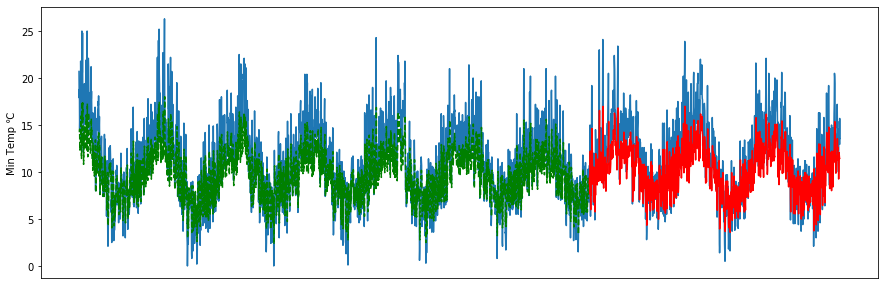

In [244]:
%matplotlib inline
# shift train predictions for plotting
trainPredictPlot = np.empty_like(mtemp_t)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(mtemp_t)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(mtemp_t)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize= [15, 5])
plt.plot(scaler.inverse_transform(mtemp_t))
plt.plot(trainPredictPlot, color='green', linestyle='dashed')
plt.plot(testPredictPlot, color='red')
plt.ylabel('Min Temp ℃')
plt.xticks([])
plt.show()

#original dataset in blue 
#predictions for the training dataset in green
#predictions on the unseen test dataset in red